<a href="https://colab.research.google.com/github/leondotle/research/blob/main/SnailsPaperAndProgramming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Turbinator.py: Making Turbinate (and Planispiral) Shell Origami Crease Patterns

This script is to generate a turbinated shell (which is to say conical, not in a plane like a planispiral shell). The Fuse method can be formed to be conical but you are working against the paper. The goal here is for a natural 3d spiral, going all the way to scalariform (whorls not touching each other). And of course, curved folds so the paper creates a life-like shell.

See the [powerpoint explanation and triangle drawings](https://github.com/eleciawhite/origami/tree/main/docs/2021%20HMC%20Alumni%20Presentation) and/or [YouTube presentation](https://youtu.be/40ammPwd_14) for more information.

Similar to my fuse_shellgen.py [and diagram](https://colab.research.google.com/drive/1NZ3piVw5GSPSz7ywfhFOCfl28BkP25RV?usp=sharing) the parameters are:
 * ca - central angle
 * sa - spirality angle
 * u - inital length of the normal (make this one)
 * N - number of iterations

However, the spiraling angle is split into two, as shown in [this diagram](https://github.com/eleciawhite/origami/blob/main/shells/pics/TurbinatorTriangleMath.jpg).
  * saL - spiraling angle on the left
  * saR - spiraling angle on the right
The central angle is also split into two caR and caL.

Since the interior line lengths will be the same, the edges of the paper will be different length. Instead of isosocele triangles, this method will make for unbalanced triangles.

The geomtry for figuring out the lines was tough, mostly careful, repeated use of the Law of Sines as well as other triangle rules. The terminology I'm using for the code depends heavily on the diagram.

As you try different parameters, you will find:
 * caR=caL and saR < saL leads to dextral chirality
 * caR=caL and sal < sar leads to sinistral chirality
 * larger sa makes for a smaller protoconch, slower growth
 * caR + caL smaller means a larger protoconch and slower, smoother growth
 * caR + caL lager larger makes for a smaller protoconch but chunkier whorls
 * unbalanced ca gives height to the coil but can lead to unbalanced tails which are hard to fold (though cutting to a kite shape can help that)

From here, we have a bit of startup and class definitions.

In [ ]:
from math import *
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import collections  as mc
from matplotlib.patches import Ellipse, Wedge, Polygon
from matplotlib.path import Path
import itertools

class point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def lengthTo(self, p):
        x2 = (self.x-p.x)**2
        y2 = (self.y-p.y)**2
        len = sqrt(x2 + y2)
        return len

    def pts(self):
        return [self.x, self.y]

    def negative(self):
        return point(self.x, -self.y)

    def pointFrom(self, length, angle):
        x = self.x + length*sin(radians(angle))
        y = self.y + length*cos(radians(angle))
        return point(x, y)


class side:
    def __init__(self, pointA, pointB):
        self.pointA = pointA
        self.pointB = pointB
    def length(self):
        return self.pointA.lengthTo(self.pointB)

Adding plots based on the curvature function passed in and the resulting Bezier curves. Note that these get added as matplotlib paths.

In [ ]:
def add_plot(paths, pt1, pt2, curve_fun, color):
    ptb = curve_fun(pt1, pt2)
    bezier(paths, pt1, pt2, ptb, color)

def bezier(paths, pt1, pt2, ptb, color):
    npoints = 2
    numbers = [i for i in range(npoints)]
    bezier_path = np.arange(0.0, 1.01, 0.02)

    x1y1 = x1, y1 = pt1.x, pt1.y
    x2y2 = x2, y2 = pt2.x, pt2.y
    xbyb = xb, yb = ptb.x, ptb.y

    # Compute and store the Bezier curve points
    x = (1 - bezier_path)** 2 * x1 + 2 * (1 - bezier_path) * bezier_path * xb + bezier_path** 2 * x2
    y = (1 - bezier_path)** 2 * y1 + 2 * (1 - bezier_path) * bezier_path * yb + bezier_path** 2 * y2

    curve = np.column_stack((x,y)).reshape(x.shape[0],2)
    paths.append([curve, color])



Here are the curve functions we might use. Note that 095 is curvier than 0975.

In [ ]:
# use for straight line versions
def ptb_straightline(pt1, pt2):
    return pt1

# Use an x division less than two or the curves fight the angle of growth
# 0975 is least curvy where 090 is very curvy
def ptb_sumxdiv0975_avey(pt1, pt2):
    divisor = 2.0 * 0.975
    xb = (pt1.x+pt2.x)/divisor
    yb = (pt1.y+pt2.y)/divisor
    return point(xb, yb)

def ptb_sumxdiv095_avey(pt1, pt2):
    divisor = 2.0 * 0.95
    xb = (pt1.x+pt2.x)/divisor
    yb = (pt1.y+pt2.y)/divisor
    return point(xb, yb)

def ptb_sumxdiv090_avey(pt1, pt2):
    divisor = 2.0 * 0.90
    xb = (pt1.x+pt2.x)/divisor
    yb = (pt1.y+pt2.y)/divisor
    return point(xb, yb)

We can reduce the tails of the paper and the clutter you have to hide in the body whorl by cutting the paper into a kite shape (instead of a triangle).

In [ ]:
# Given a line of two points P1 and P2, is P3 on this line?
# If the distance P1_P3 + P3_P2 = distance P1_P2 the P3 is on the line
def dist(x1, y1, x2, y2, x3, y3): # x3,y3 is the point to check
    p1_p2_total = sqrt((x2-x1)**2 + (y2-y1)**2)
    p1_p3 = sqrt((x3-x1)**2 + (y3-y1)**2)
    p2_p3 = sqrt((x3-x2)**2 + (y3-y2)**2)
    return (p1_p3 + p2_p3) - p1_p2_total # not really worried about actual dist so no sqrts

def cutAtIntersection(curve, line, epsilon = 0.0035):
    ((x1,y1),(x2,y2)) = line

    for i in range(curve.shape[0]):
        xc, yc = curve[i]
        d = dist(x1, y1, x2, y2, xc, yc)
        if d < epsilon:
           return curve[:i]
    return curve

Single most important function! The law of sines is:

```
length(ab)           length(bc)           length(ac)
-----------    =    -------------    =   ------------
sin(angle c)        sin(angle a)          sin(angle b)
```

This function eturns the length of a side (say bc) so
we take the length (ab), the angle c, and the angle a.

In [ ]:
def law_sines(length, ang_denom, ang_mult):
    val = length*sin(radians(ang_mult)) / sin(radians(ang_denom))
    return abs(val)

Here is where the magic happens.

Parameters:
 * prefix - used in printing a name and outputting a file
 * show_plot - if true, a plot will be show; if false, only the file will be written
 * caR and caL - central angles
 * saR and saL - spirality angles
 * u - length of initial horizontal... this ends up not mattering as everything scales so leave it as 1.0
 * N - number of horizontal lines to use
 * curve_fun - which function to use for curving the lines, same function is used on both lines
 * kite - how many horizontal lines back to start the kite, zero for no cut
 * cutProtoconch - cut off the tip of the triangle as sometimes it is not integrated into the shell.

In [ ]:
def make_plot(prefix='tb', show_plot=True,
            caR=15.0, caL=15.0, saR=12.0, saL=15.0, u=1.0, N=15,
            curve_fun=ptb_straightline, kite=0, cutProtoconch = True):

    figure, ax = plt.subplots()
    name = '{}_cal{}_car{}_sal{}_sar{}_N{}'.format(prefix, int(caL), int(caR), int(saL), int(saR), N)

    # angles from known
    angBR = 90 + (caR)
    angBL = 90 + (caL)
    angCL = 180 - angBL - saL
    angCR = 180 - angBR - saR

    # known length
    BL_BR = u

    # initial protoconch triangle
    pointA = point(0,0)
    A_BL = law_sines(BL_BR, caL + caR, 90-caR)
    A_BR = law_sines(BL_BR, caL + caR, 90-caL)
    pointBR = pointA.pointFrom(A_BR, caR)
    pointBL = pointA.pointFrom(A_BL, -caL)

    if cutProtoconch:
        outerPolyVertices = [pointBR.pts(), pointBL.pts()]
    else:
        outerPolyVertices = [pointBR.pts(), pointA.pts(), pointBL.pts()]
    prevA = pointA

    paths =[]

    for i in range(N + 1):
        angCL = 180 - angBL - saL   # recalculate as it depends on saL which can change
        angCR = 180 - angBR - saR   # recalculate as it depends on saR which can change

        # this is a magical incantation supported by the unholy art of geometry
        saSinRatio = sin(radians(saR)) / sin(radians(saL))
        numerator = BL_BR * sin(radians(angBL)) * sin(radians(angBR))
        denom_A =  saSinRatio * sin(radians(angCL)) * sin(radians(angBR))
        denom_B = sin(radians(angCR)) * sin(radians(angBL))
        A_CR =  numerator / (denom_A + denom_B)

        A_CL = law_sines(A_CR, saL, saR)
        A_BL = law_sines(A_CL, angBL, angCL)
        A_BR = law_sines(A_CR, angBR, angCR)

        pointA = pointBL.pointFrom(A_BL, 90.0)
        pointBR = pointA.pointFrom(A_BR, 90.0)
        pointCR = pointA.pointFrom(A_CR, 90-saR)
        pointCL = pointA.pointFrom(A_CL, -(90-saL))


        if i != N: # last pass is for the outer cut

            if curve_fun==ptb_straightline:
                add_plot(paths, pointBL, pointBR, color='r',
                    curve_fun=curve_fun)
            else:
                # for debugging, making these different colors is handy
                add_plot(paths, pointA, pointBR, color='r',
                    curve_fun=curve_fun)
                add_plot(paths, pointA, pointBL, color='r',
                    curve_fun=curve_fun)

            add_plot(paths, pointA, pointCL, color='b',
                curve_fun=curve_fun)
            add_plot(paths, pointA, pointCR, color='b',
                curve_fun=curve_fun)

            if i == (N-kite):
                kiteBL = pointBL
                kiteBR = pointBR

            if cutProtoconch==False and i == 0:
                add_plot(paths, prevA, pointA, color='g', curve_fun=ptb_straightline)

            pointBL = pointCL
            pointBR = pointCR
            BL_BR = pointCL.lengthTo(pointCR)
            prevA = pointA

    if kite == 0:
        outerPolyVertices.extend([pointCL.pts(), pointCR.pts()])
    else: # cut off kite and also modify the lines
        halfC = pointCL.lengthTo(pointCR)/2.0
        outerPolyVertices.extend([kiteBL.pts(), pointCL.pointFrom(halfC, 90).pts(),kiteBR.pts()])
        left = [kiteBL.pts(), pointCL.pointFrom(halfC, 90).pts()]
        right = [pointCL.pointFrom(halfC, 90).pts(),kiteBR.pts()]

        Npaths = len(paths)
        curves_per_whorl = 4
        for i in range(Npaths-(kite*curves_per_whorl), Npaths):
            curve, color = paths[i]
            curve = cutAtIntersection(curve, left)
            curve = cutAtIntersection(curve, right)
            paths[i] = (curve,color)

    for curve, color in paths:
           ax.plot(curve[:,0], curve[:,1], color)

    poly = Polygon(outerPolyVertices, facecolor='1.0', edgecolor='k')
    p = ax.add_patch(poly)

    plt.axis('off')
    plt.box(False)

    ax.set_aspect(1), ax.autoscale()
    plt.savefig(name + ".svg")
    if show_plot: plt.title(name), plt.show()



Now, let's make some plots, these are the standard ones.

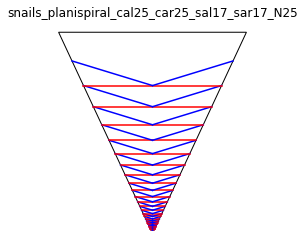

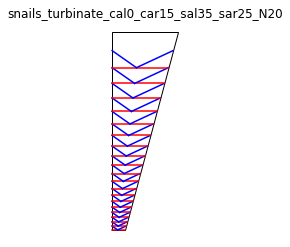

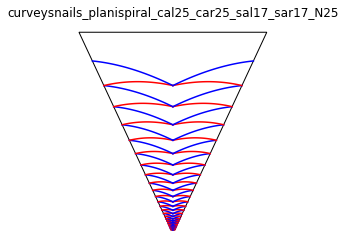

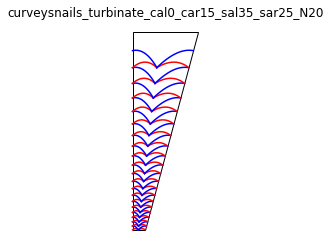

In [ ]:
name = 'snails_'
make_plot(prefix=name+'planispiral', caL =25, caR = 25, saL=17, saR=17, u=1.0, N=25, curve_fun=ptb_straightline)
make_plot(prefix=name+'turbinate', caL =0, caR = 15, saL=35, saR=25, u=1.0, N=20, curve_fun=ptb_straightline)


name = 'curveysnails_'
make_plot(prefix=name+'planispiral', caL =25, caR = 25, saL=17, saR=17, u=1.0, N=25, curve_fun=ptb_sumxdiv095_avey)
make_plot(prefix=name+'turbinate', caL =0, caR = 15, saL=35, saR=25, u=1.0, N=20, curve_fun=ptb_sumxdiv095_avey)


I used a Cricut to precrease my shells.

To load the SVG in to the Cricut program:
1. Upload the SVG
2. In layers, delete the outer box
3. Select the rest, Edit->Score
4. Choose the outer edge, the last item in the layers, Edit->Cut

Curved crease versions should be done with cardstock. Straight line snails can be folded from most any paper. There is a [slide in the presentation](https://github.com/eleciawhite/origami/tree/main/docs/2021%20HMC%20Alumni%20Presentation) (after Thank You) that shows the steps for folding these.


So now let's look at some more experimental snails... these may not work well.

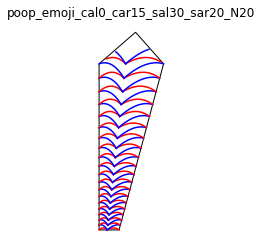

In [ ]:
make_plot(prefix='poop_emoji', caL =0, caR = 15, saL=30, saR=20, u=1.0, N=20, curve_fun=ptb_sumxdiv095_avey, kite=1) # 11.5" long, 65lbs cardstock, difficult fold
